In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import utils as ut
import m_models as mm
import os
from tqdm import tqdm_notebook as tqdm

import pylab

import statsmodels.api as sm

import scipy.stats as sps
from scipy.optimize import minimize_scalar as minimize_scalar

import pickle

from sklearn.linear_model import Lasso

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']= 36
plt.rcParams['axes.labelsize']= 40
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

---

In [3]:
N = 10
M = 1000
sigma = 1

bootstrap_num_iter = 1000

---
Генерируем выборку

In [12]:
w = sps.uniform().rvs(N)

X = sps.norm(loc=0, scale=1).rvs(size=(M, N))
y = X @ w + sps.norm(loc=0, scale=sigma).rvs(size=M)

/home/coder/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/coder/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


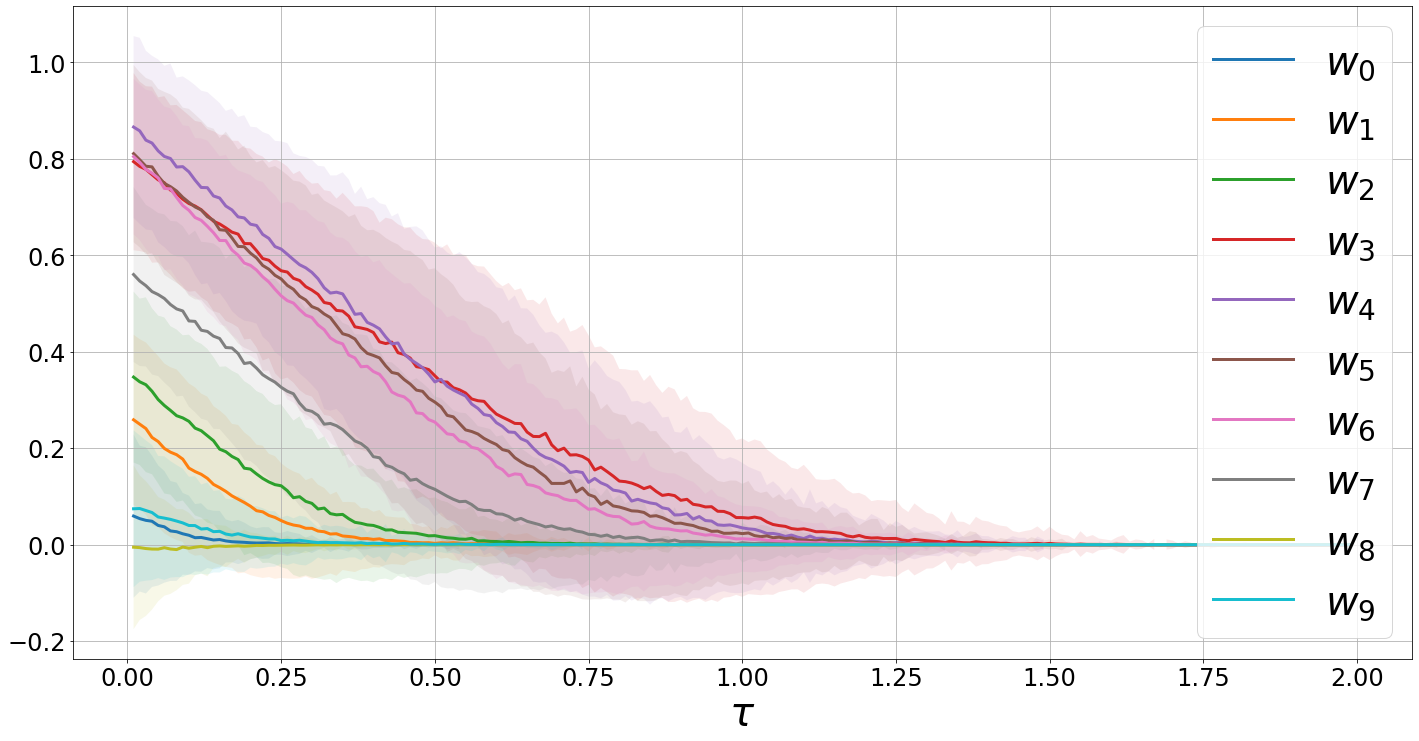

In [16]:
m_0 = 100
W = []
W_std = []

alphas = np.arange(0.01, 2, 0.01)

for alpha in tqdm(alphas):
    
    w_hats = []
    
    for i in range(bootstrap_num_iter):
        
        idx = np.random.choice(M, size=m_0)
        
        X_cur = X[idx]
        y_cur = y[idx]
        
        cur_model = Lasso(alpha=alpha)
        cur_model.fit(X_cur, y_cur)
        w_hats.append(cur_model.coef_)
    
    W.append(np.mean(w_hats, axis=0))
    W_std.append(np.std(w_hats, axis=0))
    
W = np.asarray(W)
W_std = np.asarray(W_std)

for i in range(N):
    plt.plot(alphas, W[:, i], label='$w_{' + str(i) + '}$')
    plt.fill_between(alphas, sps.norm(loc=W[:, i], scale=W_std[:, i]).ppf(0.05), sps.norm(loc=W[:, i], scale=W_std[:, i]).ppf(0.95),
                 alpha=0.1)

plt.xlabel('$\\tau$')
plt.legend()
plt.grid()
plt.savefig('../data/pics/synthetic_lasso_W.pdf', format='pdf')
plt.show()

---
Запомним те $\alpha$, при которых обнуляется очередной коэффициент

In [17]:
alpha_threshold = []

for i in range(N):
    alpha_threshold.append((alphas[np.argmax(W[:, i] < 0.05)], i))
    
alpha_threshold = sorted(alpha_threshold)
alpha_threshold = np.asarray([[t[0], t[1]] for t in alpha_threshold])

---
Построим зависимость функции ошибки от объема выборки при разном колисестве признаков

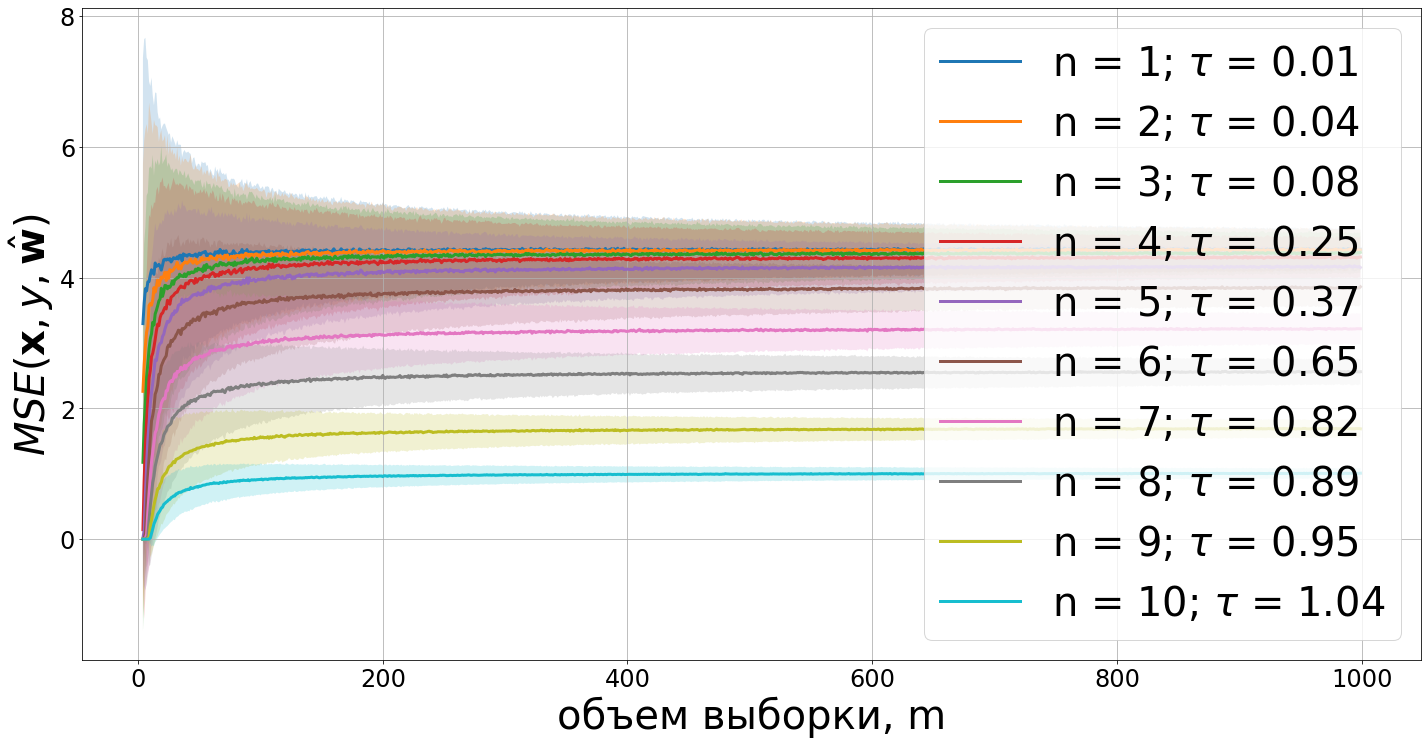

In [20]:
S = []
std = []

for j in tqdm(range(N)):

    S_cur = []
    std_cur = []
    
    X_j = X[:, alpha_threshold[:j + 1, 1].astype(np.int32)]
    y_j = y

    for m_0 in range(4, M):

        mse = []

        for i in range(bootstrap_num_iter):

            idx = np.random.choice(M, size=m_0)

            X_cur = X_j[idx]
            y_cur = y_j[idx]

            w_hat = ut.get_params(X_cur, y_cur)
            mse.append(np.mean((X_cur @ w_hat - y_cur) ** 2))
    #         mse.append(np.exp(-np.mean((X_cur @ w_hat - y_cur) ** 2)))

        S_cur.append(np.mean(mse))
        std_cur.append(np.std(mse))

    S_cur = np.asarray(S_cur)
    std_cur = np.asarray(std_cur)
    
    S.append(S_cur)
    std.append(std_cur)

    plt.plot(np.arange(4, M), S[j], label='n = {}'.format(j + 1) + '; $\\tau$ = {}'.format(round(alpha_threshold[j, 0], 2)))
    plt.fill_between(np.arange(4, M), sps.norm(loc=S[j], scale=std[j]).ppf(0.05), sps.norm(loc=S[j], scale=std[j]).ppf(0.95),
                     alpha=0.2)
    
S = np.asarray(S)
std = np.asarray(std)

plt.xlabel('объем выборки, m')
plt.ylabel('$MSE(\mathbf{x}, y, \hat{\mathbf{w}})$')
plt.legend()
plt.grid()
    
plt.savefig('../data/pics/synthetic_MSE_n.pdf', format='pdf')

plt.show()

In [21]:
X_axis = np.arange(20, M)
Y_axis = np.arange(N)
XX, YY = np.meshgrid(X_axis, Y_axis)
ZZ = S[:, 20-4:]

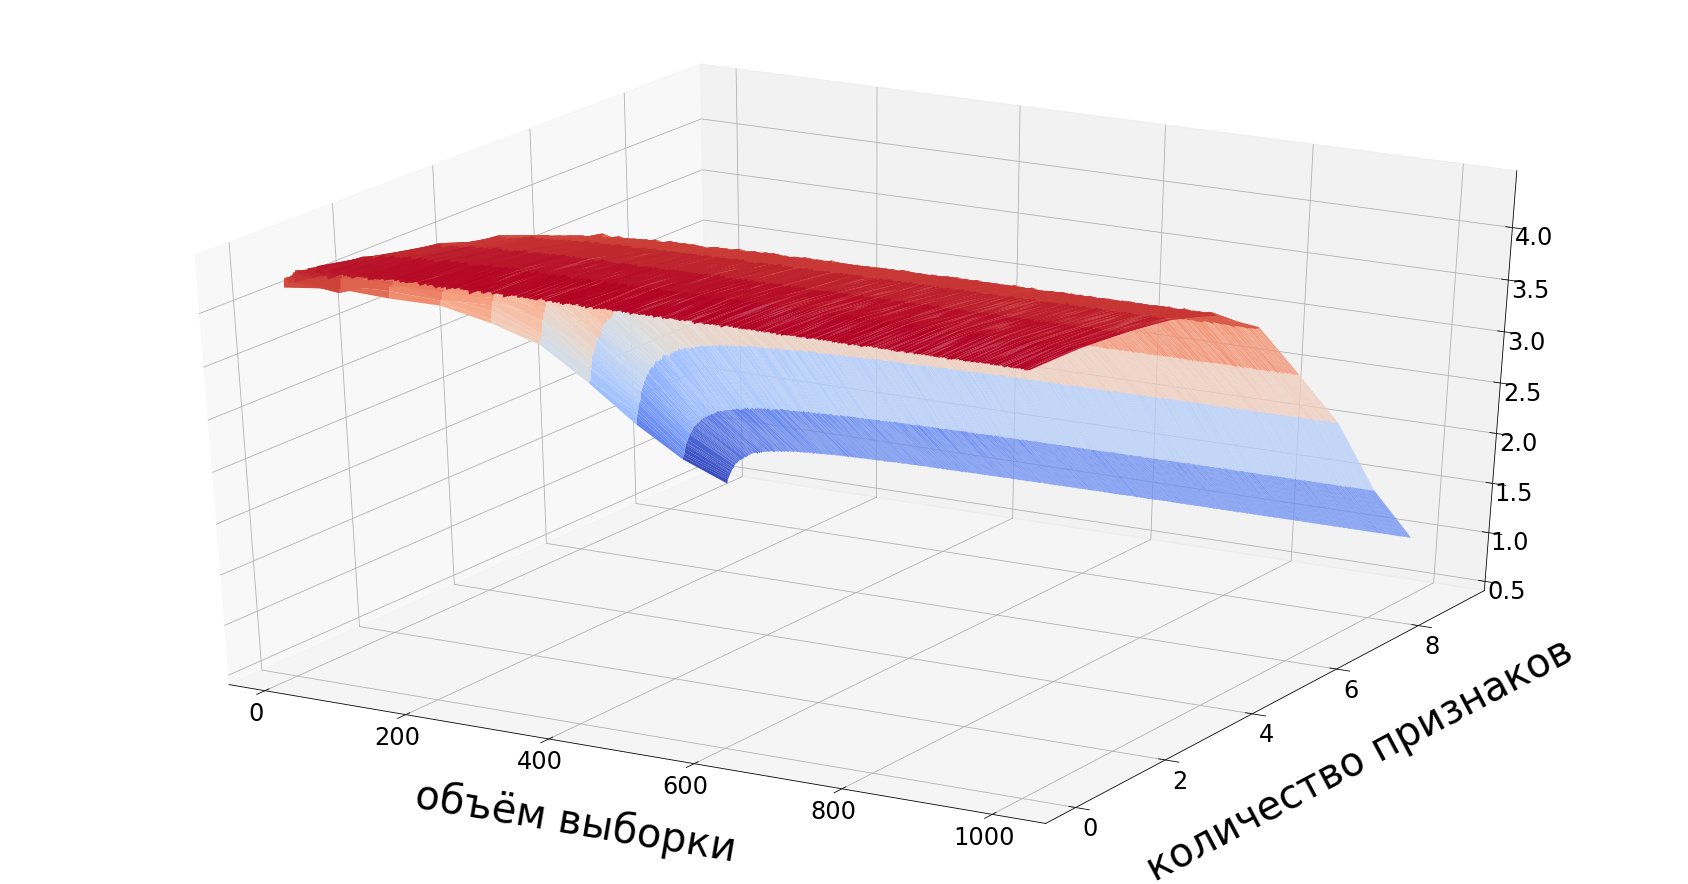

In [22]:
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, cmap=cm.coolwarm)
plt.xlabel('объём выборки', labelpad=50)
plt.ylabel('количество признаков', labelpad=50)
plt.savefig('../data/pics/synthetic_MSE_surface.pdf', format='pdf')